# Cross Correlation of Actin and Myosin Channels

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage.morphology import closing
from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median
from skimage import io
from scipy.ndimage import distance_transform_edt
import napari
from skimage.filters import gaussian
from skimage.measure import regionprops_table
from scipy.ndimage import gaussian_filter1d
from scipy.signal import correlate, correlation_lags


In [6]:
from cellpose import models

In [7]:
def drop_scattered_small_labels(label_image, min_size=100):
    """
    Removes small scattered regions of each label from a labeled image.

    Parameters:
    - label_image: 2D numpy array representing the labeled image.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed image with small scattered labels dropped.
    """
    label_image = closing(label_image)
    unique_labels = np.unique(label_image)
    output_image = np.zeros_like(label_image)

    for label in unique_labels:
        if label == 0:  # Assuming 0 is the background
            continue

        # Create a binary image for the current label
        binary_mask = label_image == label

        # Identify separate regions of the current label
        labeled_mask, num_features = ndimage.label(binary_mask)

        # Measure the size of each region
        sizes = ndimage.sum(binary_mask, labeled_mask, range(num_features + 1))

        # Create a mask of regions to be kept for the current label
        mask_size = sizes >= min_size
        keep = mask_size[labeled_mask]

        # Update the output image with regions of the current label that are kept
        output_image[keep] = label

    return output_image


def process_time_series_label_images(time_series_label_images, min_size=100):
    """
    Processes a time-series of label images by removing small scattered labels.

    Parameters:
    - time_series_label_images: 3D numpy array representing a time-series of labeled images.
      The first dimension is time.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed time-series with small scattered labels dropped from each frame.
    """

    # Get the number of time points
    T = time_series_label_images.shape[0]

    # Initialize an output array of the same shape as the input
    output_images = np.zeros_like(time_series_label_images)

    for t in range(T):
        output_images[t] = drop_scattered_small_labels(time_series_label_images[t], min_size=min_size)

    return output_images


def match_histogram(source, template):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=65536, range=(0, 65536))
    hist_template, _ = np.histogram(template.ravel(), bins=65536, range=(0, 65536))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(65536, dtype=np.uint16)
    j = 0
    for i in range(65536):
        while cdf_template[j] < cdf_source[i] and j < 65535:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched


def match_histogram_stack(img_stack, template):
    matched_stack = np.zeros_like(img_stack)
    for i in range(img_stack.shape[0]):
        matched_stack[i] = match_histogram(img_stack[i], template)
    return matched_stack

def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack

In [8]:
unstable_fibres = io.imread("transfer_187559_files_94515bab/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage1__Position_11_.tiff")
stable_fibres = io.imread("transfer_187559_files_94515bab/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage2__Position_12_.tiff")

In [9]:
from tqdm.auto import tqdm

myosin_bl = []
rGBD_bl = []
actin_bl = []

myosin = stable_fibres[..., 1]
rGBD = stable_fibres[..., 2]
actin = stable_fibres[..., 0]
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]
myosin_bl.append(np.stack([match_histogram(img, reference_myosin) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin) for img in tqdm(actin)]))
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

In [10]:
binned_actin = blockwise_median(actin, (1, 3, 3))

In [11]:
model = models.Cellpose(gpu=True, model_type="cyto2")

In [12]:
seg_cp = np.zeros_like(binned_actin)

In [13]:
for idx, img in enumerate(binned_actin):
    masks, flows, styles, diams = model.eval(img, diameter=60, channels=[0, 0], do_3D=False, net_avg=True)
    seg_cp[idx] = masks

In [14]:
dist_transform = []
for i in seg_cp:
    dist_transform.append(distance_transform_edt(i).astype(np.uint16))

dist_transform = np.stack(dist_transform)
viewer = napari.Viewer()
viewer.add_image(dist_transform)

<Image layer 'dist_transform' at 0x7fe7e9c8c700>

In [15]:
actin_bg = remove_image_background(binned_actin, size=(100, 1, 1), filter_type="median", crop_time_axis=True)
actin_bg = np.where(actin_bg < 0, 0, actin_bg)

In [16]:
test = gaussian(actin_bg, sigma=1)

In [17]:
test_no_edge = np.where((dist_transform[50:-50] < 5), 0, test)

In [18]:
events_1 = track_events_image(test_no_edge > 40, eps=3, epsPrev=3, minClSz=8, predictor=True, nPrev=3, downsample=1)

100%|██████████| 621/621 [00:05<00:00, 120.11it/s]


In [19]:
events_1_filtered = process_time_series_label_images(events_1, 5)
events_1_filtered = filter_by_duration(events_1_filtered, 10)

In [20]:
events_upscaled = []
for t in events_1_filtered:
    t_img = upscale_image(t, 3)
    events_upscaled.append(t_img)

events_upscaled = np.stack(events_upscaled)

In [21]:
reshaped_stable_fibres = stable_fibres[50:-50]

In [22]:
df_all = []

middle_frame = 193
label_image = events_upscaled[middle_frame] == 60
min_frame_range = middle_frame - 50
max_frame_range = middle_frame + 50
intensity_image = reshaped_stable_fibres[min_frame_range:max_frame_range]
for idx, e in enumerate(intensity_image):
    props = regionprops_table(label_image.astype(int), properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=e[:, :1160])
    df_temp = pd.DataFrame(props)
    df_temp["frame"] = idx -10
    df_all.append(df_temp)

df_all_concat = pd.concat(df_all)

<Axes: xlabel='frame'>

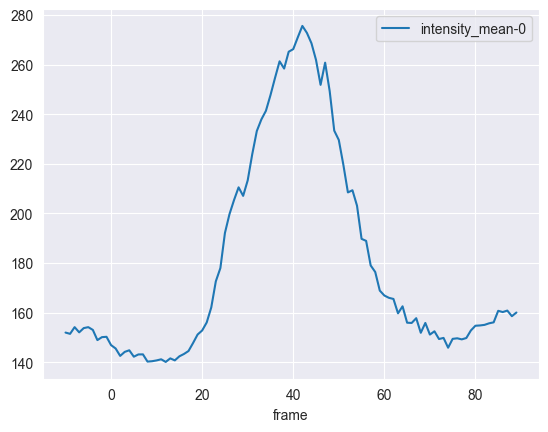

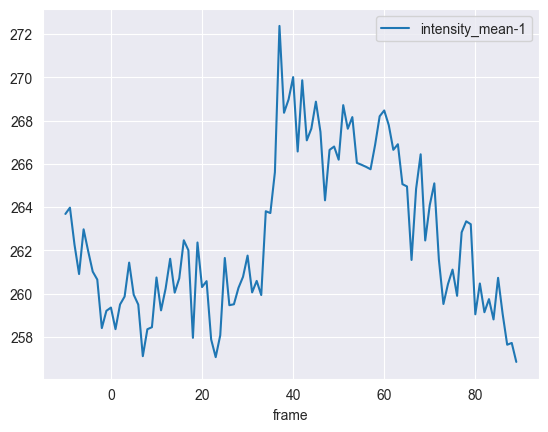

In [23]:
df_all_concat.plot(x='frame', y='intensity_mean-0')
df_all_concat.plot(x='frame', y='intensity_mean-1')

In [56]:
import pandas as pd
from skimage.measure import regionprops_table

df_all_several_frames = []

for middle_frame in range(180, 246, 1):  
    label_image = events_upscaled[middle_frame] == 60
    min_frame_range = middle_frame - 50
    max_frame_range = middle_frame + 50
    intensity_image = reshaped_stable_fibres[min_frame_range:max_frame_range]

    for idx, e in enumerate(intensity_image):
        props = regionprops_table(label_image.astype(int), properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=e[:, :1160])
        df_temp_several_frames = pd.DataFrame(props)
        df_temp_several_frames["frame"] = idx - 10
        df_all_several_frames.append(df_temp_several_frames)

df_all_several_frames = pd.concat(df_all_several_frames, ignore_index=True)


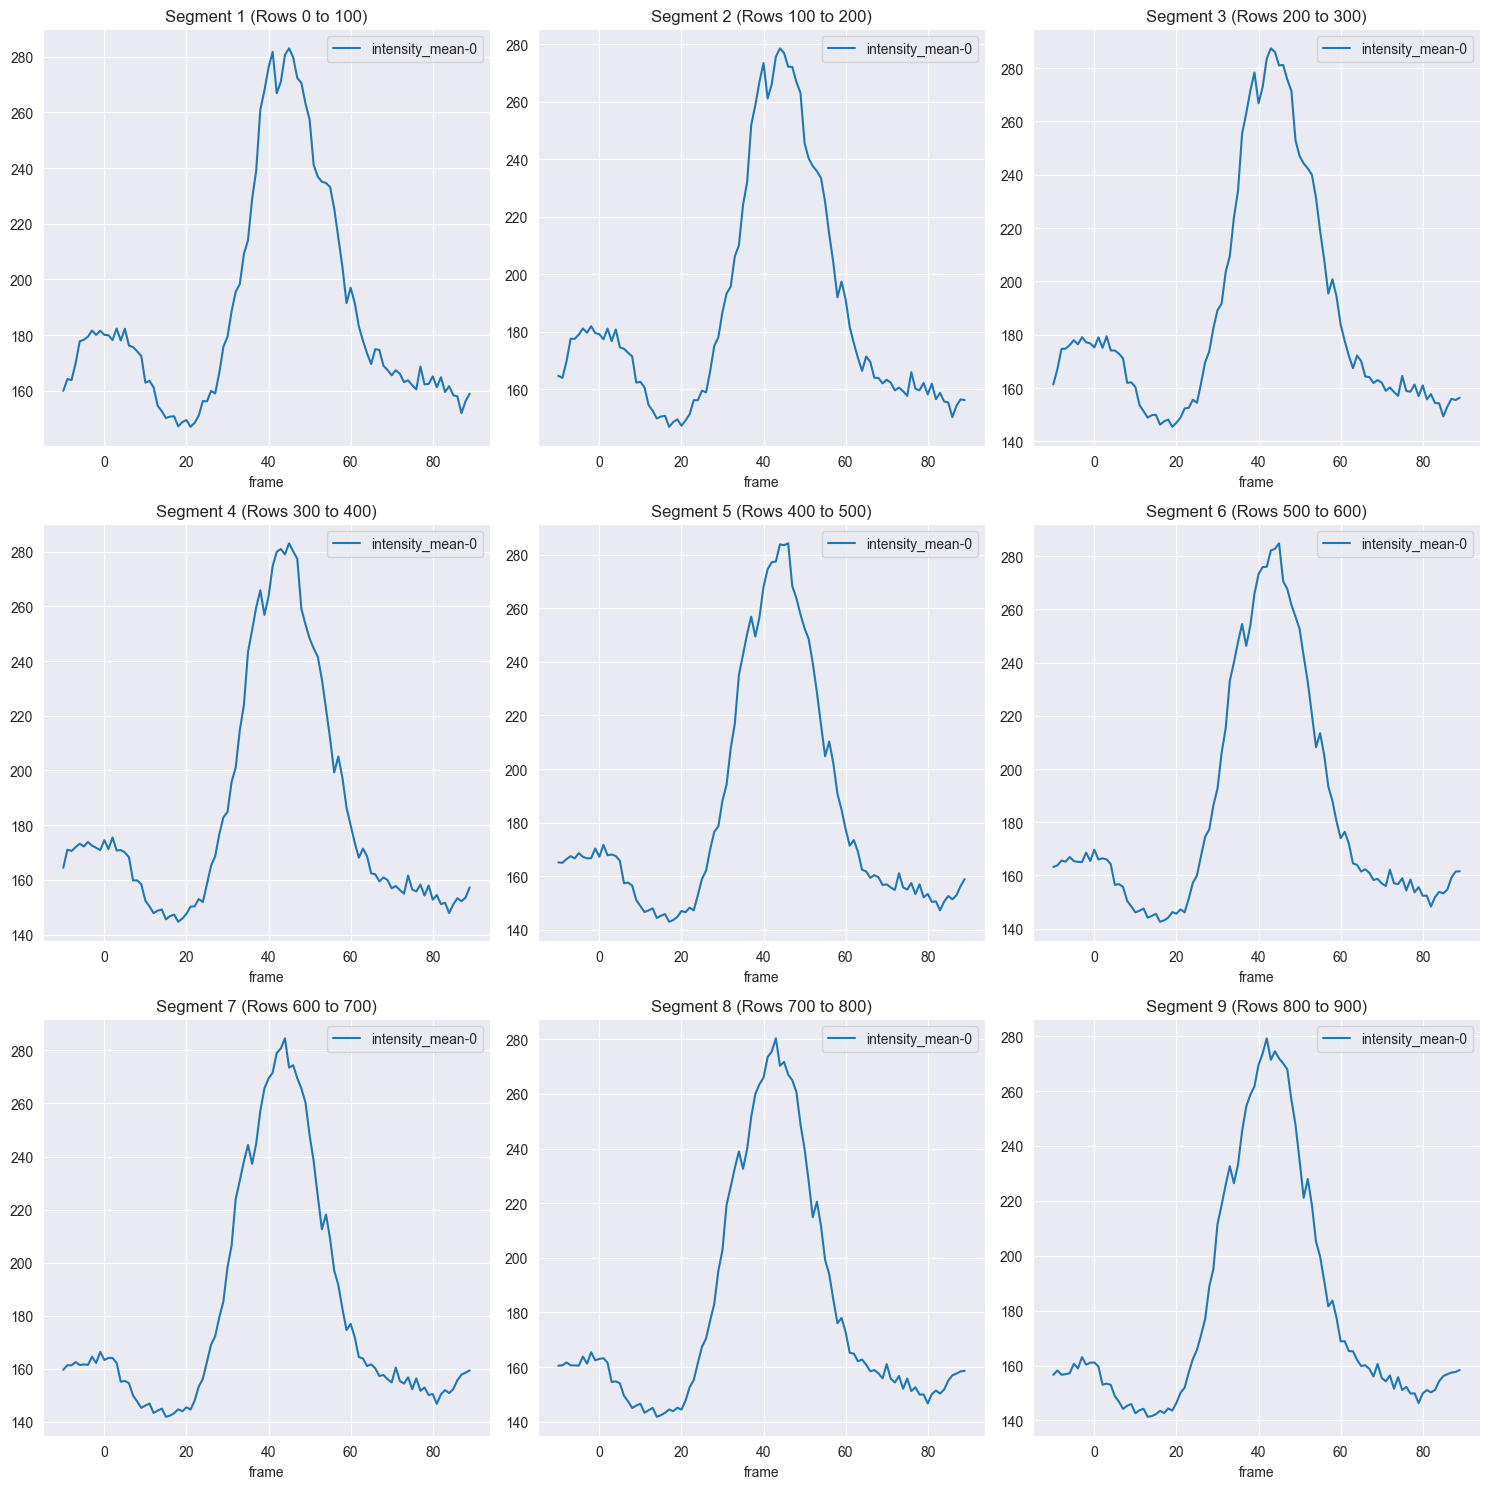

In [255]:
# Creating a 3x3 grid of plots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plotting the data in segments on the grid
for i, ax in enumerate(axes):
    start_row = i * 100
    end_row = start_row + 100
    df_all_several_frames.iloc[start_row:end_row].plot(x='frame', y='intensity_mean-0', ax=ax)
    ax.set_title(f'Segment {i+1} (Rows {start_row} to {end_row})')

plt.tight_layout()
plt.show()

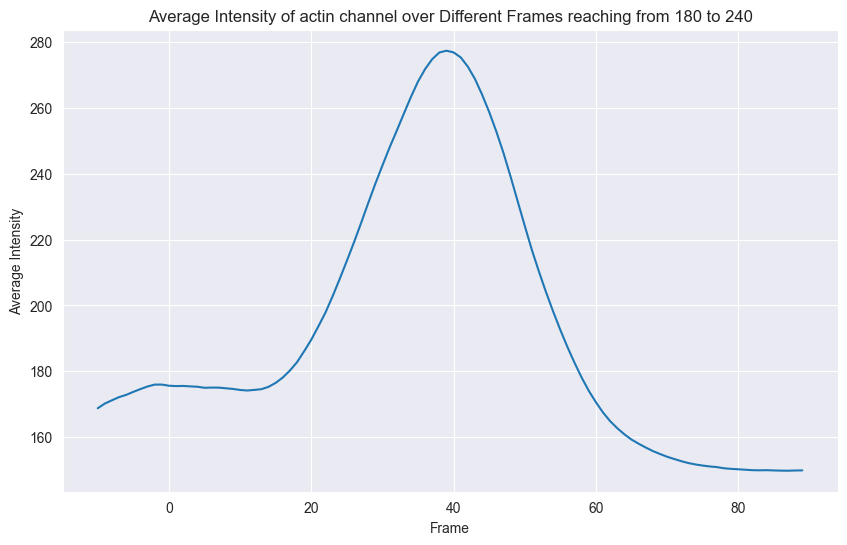

In [254]:
average_intensities_actin = df_all_several_frames.groupby('frame')['intensity_mean-0'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_actin.plot()

plt.title("Average Intensity of actin channel over Different Frames reaching from 180 to 240")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_actin.png")
plt.show()

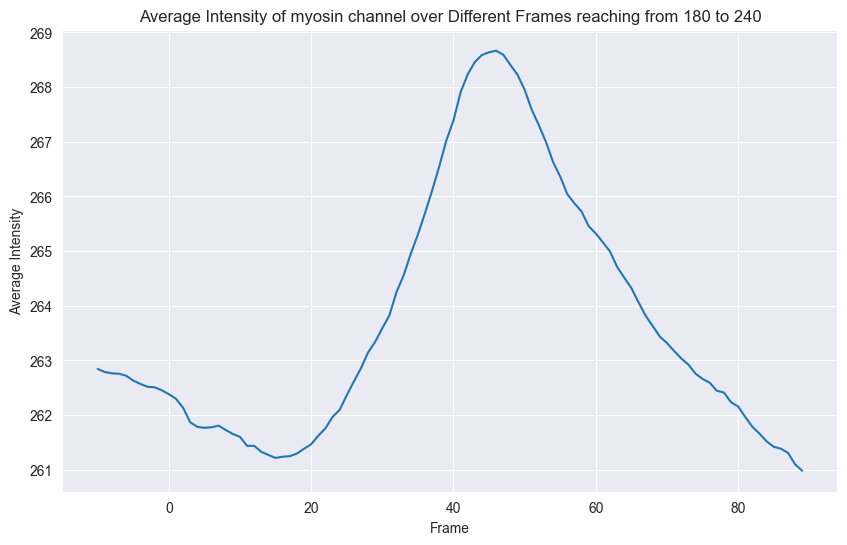

In [99]:
average_intensities_myosin = df_all_several_frames.groupby('frame')['intensity_mean-1'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_myosin.plot()

plt.title("Average Intensity of myosin channel over Different Frames reaching from 180 to 240")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()

## rGBD channel

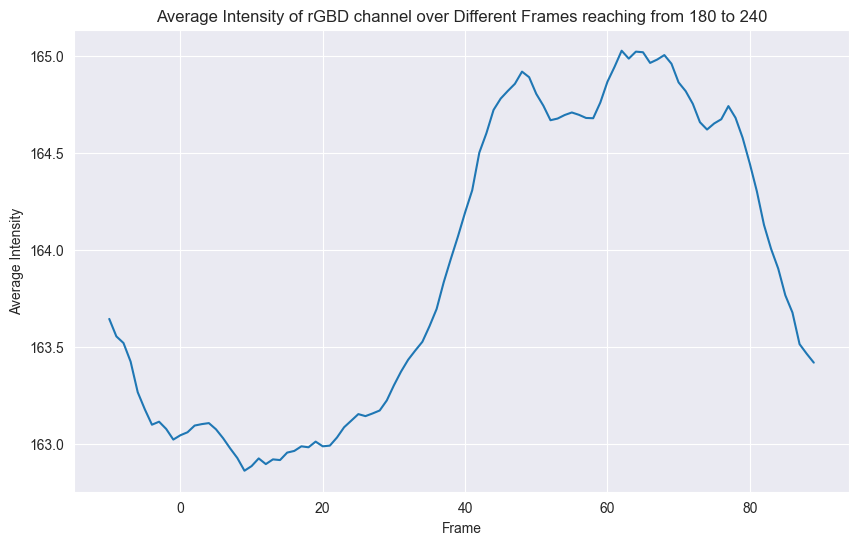

In [259]:
average_intensities_rgbd = df_all_several_frames.groupby('frame')['intensity_mean-2'].mean()

# Plotting
plt.figure(figsize=(10, 6))
average_intensities_rgbd.plot()

plt.title("Average Intensity of rGBD channel over Different Frames reaching from 180 to 240")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()

In [199]:
actin_min = average_intensities_actin.min()
actin_max = average_intensities_actin.max()
normalized_actin_intensities = (average_intensities_actin - actin_min) / (actin_max - actin_min)

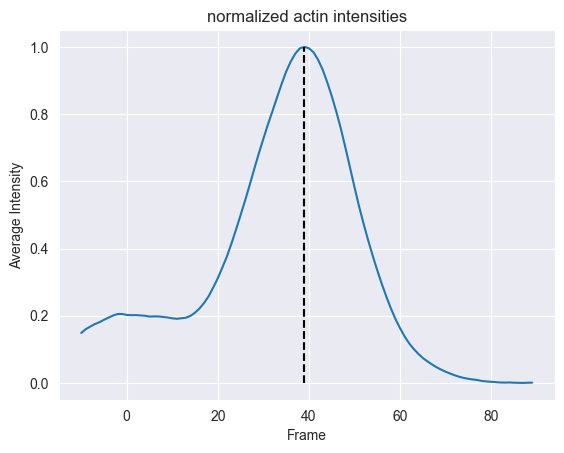

Frame at which actin intensity is max: 39


In [219]:
index_of_norm_actin = np.argmax(normalized_actin_intensities)
plt.plot(normalized_actin_intensities)
plt.title("normalized actin intensities")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
plt.vlines(index_of_norm_actin-10, 0, max(normalized_actin_intensities), colors='k', linestyles='dashed')
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()

print(f"Frame at which actin intensity is max: {index_of_norm_actin-10}")

In [260]:
rgbd_min = average_intensities_rgbd.min()
rgbd_max = average_intensities_rgbd.max()
normalized_rgbd_intensities = (average_intensities_rgbd - rgbd_min) / (rgbd_max - rgbd_min)

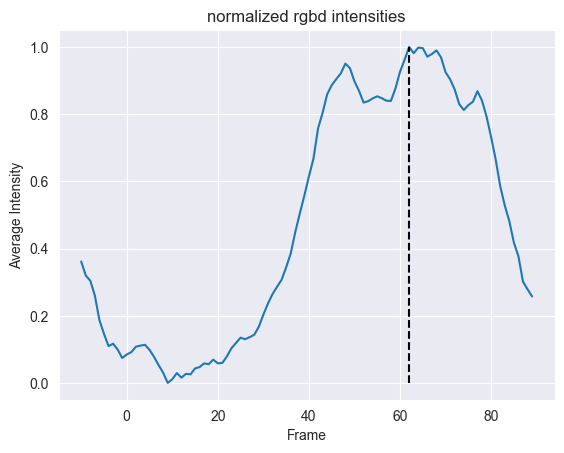

In [261]:
index_of_norm_rgbd = np.argmax(normalized_rgbd_intensities)
plt.plot(normalized_rgbd_intensities)
plt.title("normalized rgbd intensities")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")
plt.vlines(index_of_norm_rgbd-10, 0, max(normalized_rgbd_intensities), colors='k', linestyles='dashed')
#plt.savefig("plots/average_intensity_myosin.png")
plt.show()

In [203]:
myosin_min = average_intensities_myosin.min()
myosin_max = average_intensities_myosin.max()
normalized_myosin_intensities = (average_intensities_myosin - myosin_min) / (myosin_max - myosin_min)

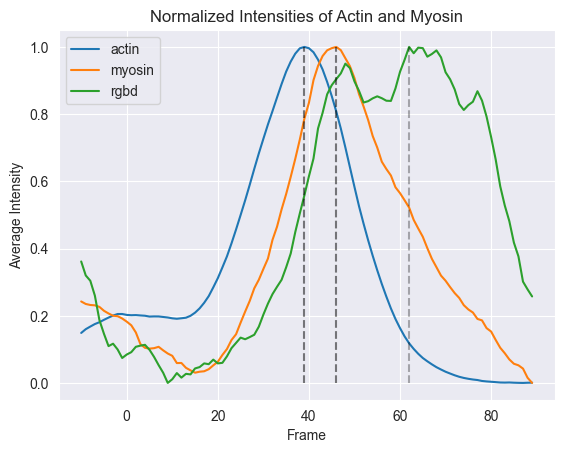

Frame at which myosin intensity is max: 46
Frame at which actin intensity is max: 39
Frame at which rgbd intensity is max: 62


In [264]:

# Find the index of maximum intensity
index_of_norm_myosin = np.argmax(normalized_myosin_intensities)

# Plot the normalized myosin intensities
plt.plot(normalized_actin_intensities, label="actin")
plt.plot(normalized_myosin_intensities, label="myosin")
plt.plot(normalized_rgbd_intensities, label="rgbd")
plt.title("Normalized Intensities of Actin and Myosin")
plt.xlabel("Frame")
plt.ylabel("Average Intensity")

# Add a vertical line at the index of maximum intensity
plt.vlines(index_of_norm_myosin-10, 0, max(normalized_myosin_intensities), colors='k', linestyles='dashed', alpha=0.5)
plt.vlines(index_of_norm_actin-10, 0, max(normalized_actin_intensities), colors='k', linestyles='dashed', alpha=0.5)
plt.vlines(index_of_norm_rgbd-10, 0, max(normalized_rgbd_intensities), colors='k', linestyles='dashed', alpha=0.3)
plt.legend()
#plt.savefig("plots/normalized_intensities_both.png")
plt.show()

print(f"Frame at which myosin intensity is max: {index_of_norm_myosin-10}")
print(f"Frame at which actin intensity is max: {index_of_norm_actin-10}")
print(f"Frame at which rgbd intensity is max: {index_of_norm_rgbd-10}")

In [265]:
corr = correlate(normalized_myosin_intensities, normalized_actin_intensities, mode="full")
reference_corr = correlate(normalized_actin_intensities, normalized_actin_intensities, mode="full")
corr_rgbd = correlate(normalized_rgbd_intensities, normalized_actin_intensities, mode="full")
corr


array([1.97688114e-04, 3.24682883e-04, 3.18122070e-04, 3.75858561e-04,
       5.30689985e-04, 8.38766131e-04, 1.05292968e-03, 1.34002081e-03,
       1.88802145e-03, 2.68127814e-03, 3.68719333e-03, 5.00361972e-03,
       6.96494163e-03, 9.23793447e-03, 1.19691206e-02, 1.52776952e-02,
       1.93211151e-02, 2.43158746e-02, 3.04125041e-02, 3.76527037e-02,
       4.62866124e-02, 5.63278066e-02, 6.80852581e-02, 8.16609277e-02,
       9.71708640e-02, 1.15184087e-01, 1.36144342e-01, 1.60465820e-01,
       1.88973742e-01, 2.22457968e-01, 2.61356677e-01, 3.06540570e-01,
       3.58713989e-01, 4.18226811e-01, 4.85595405e-01, 5.61161379e-01,
       6.45317927e-01, 7.38442805e-01, 8.40840207e-01, 9.53406424e-01,
       1.07605485e+00, 1.20834268e+00, 1.34921950e+00, 1.49689297e+00,
       1.64985017e+00, 1.80662010e+00, 1.96583244e+00, 2.12538050e+00,
       2.28335605e+00, 2.43719079e+00, 2.58489375e+00, 2.72451953e+00,
       2.85330815e+00, 2.96978317e+00, 3.07313466e+00, 3.16245984e+00,
      

In [245]:
lags = correlation_lags(len(normalized_actin_intensities), len(normalized_myosin_intensities))
lags

array([-99, -98, -97, -96, -95, -94, -93, -92, -91, -90, -89, -88, -87,
       -86, -85, -84, -83, -82, -81, -80, -79, -78, -77, -76, -75, -74,
       -73, -72, -71, -70, -69, -68, -67, -66, -65, -64, -63, -62, -61,
       -60, -59, -58, -57, -56, -55, -54, -53, -52, -51, -50, -49, -48,
       -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35,
       -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22,
       -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,
        -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,
         5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
        57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  8

In [246]:
interp_factor = 1
spf = 5

In [247]:
#corr /= np.max(corr)
corr_0 = corr
delay = np.argmax(corr_0)
print(delay)
delay_s_0 = delay/interp_factor
print(delay_s_0)

108
108.0


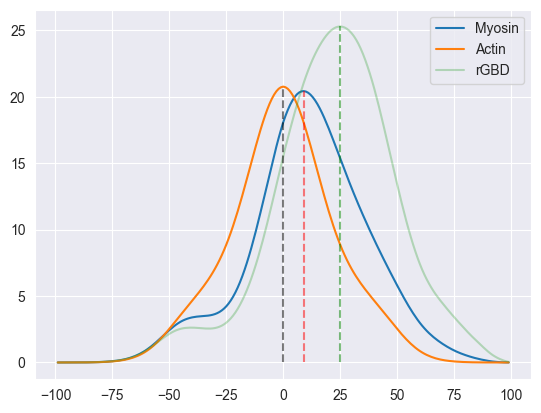

9.0


In [269]:
index_of_max_corr = np.argmax(corr)  
x_coordinate = lags[index_of_max_corr] / interp_factor  

index_of_max_corr_rgbd = np.argmax(corr_rgbd)
x_coordinate_rgbd = lags[index_of_max_corr_rgbd] / interp_factor

plt.plot(lags/interp_factor, corr, label="Myosin")
plt.plot(lags/interp_factor, reference_corr, label="Actin")
plt.plot(lags/interp_factor, corr_rgbd, label="rGBD", alpha=0.3)
plt.legend()
plt.vlines(0, 0, max(reference_corr), color="black", linestyle="dashed", alpha=0.5)
plt.vlines(x_coordinate, 0, max(corr), color="red", linestyle="dashed", alpha=0.5)
plt.vlines(x_coordinate_rgbd, 0, max(corr_rgbd), color="green", linestyle="dashed", alpha=0.5)
#plt.savefig("plots/cross_correlation.png")
plt.show()
print(x_coordinate)